In [1]:
import time
import stim
from qiskit import QuantumCircuit, QuantumCircuit
import numpy as np
from qiskit.quantum_info import DensityMatrix, Kraus
from qiskit_aer import AerSimulator, AerError

stim_circuits = {}
qiskit_circuits = {}

distances = range(3,49,2)
for d in distances:
    circuit = stim.Circuit.generated(
        code_task="repetition_code:memory",
        distance=d,
        rounds=1
    )
    circuit_clean = stim.Circuit()
    for instr in circuit:
        if instr.name not in ("DETECTOR", "OBSERVABLE_INCLUDE", "R"):
            circuit_clean.append(instr)

    stim_circuits[d] = circuit_clean

    qasm_str = stim_circuits[d].to_qasm(open_qasm_version=2, skip_dets_and_obs=True)
    with open(f"qasm_circuits/qasm{d}.txt", "w") as file:
        file.write(qasm_str)

    qiskit_circuits[d] = QuantumCircuit.from_qasm_str(qasm_str)

print(stim_circuits[3])

TICK
CX 0 1 2 3
TICK
CX 2 1 4 3
TICK
MR 1 3
M 0 2 4


**Density Matrix Method**

In [2]:
from qiskit.circuit import ClassicalRegister

#Parameters
T1 = 10 ** -4

exact_params = []
tau = T1/10 
T2 = T1


qiskit_times = []
for d in distances:
    qc = qiskit_circuits[d]
    average_time = 0
    prepend = QuantumCircuit(qc.num_qubits)
    # print(temp)
    lam = 1/T2 - 1/(2*T1)
    p_amp = 1-np.exp(-tau/T1)
    p_phase = 1-np.exp(-lam*tau)

    #Kraus

    #Amplitude damping (T1)
    K1_amp = np.array([[1, 0], [0, np.sqrt(1 - p_amp)]])
    K2_amp = np.array([[0, np.sqrt(p_amp)], [0, 0]])
    amp_damping = Kraus([K1_amp, K2_amp])

    #Phase damping (T2)
    #Preskill
    K1_phase = np.array([[np.sqrt(1 - p_phase), 0], [0, np.sqrt(1 - p_phase)]])
    K2_phase = np.array([[np.sqrt(p_phase), 0], [0, 0]])
    K3_phase = np.array([[0, 0], [0, np.sqrt(p_phase)]])
    phase_damping = Kraus([K1_phase, K2_phase, K3_phase])

    #Add decoherence
    for n in range(qc.num_qubits):
        prepend.append(amp_damping.to_instruction(), [n])
        prepend.append(phase_damping.to_instruction(), [n])
    
    combined = prepend.compose(qc)

    sim = AerSimulator(method='density_matrix')

    start_time = time.time()
    result = sim.run(combined).result()
    end_time = time.time()

    if result.success:
        elapsed_time = end_time - start_time
        qiskit_times.append(elapsed_time)
    else:
        print(f"Simulation failed with status: {result.status}")

# print(qiskit_times)


Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-197 using the density_matrix simulator. Required memory: 262144M, max memory: 16384M
Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-198 using the density_matrix simulator. Required memory: 67108864M, max memory: 16384M
Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-199 using the density_matrix simulator. Required memory: 17179869184M, max memory: 16384M
Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-200 using the density_matrix simulator. Required memory: 4398046511104M, max memory: 16384M
Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-201 using the de

Simulation failed with status: ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-197 using the density_matrix simulator. Required memory: 262144M, max memory: 16384M
Simulation failed with status: ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-198 using the density_matrix simulator. Required memory: 67108864M, max memory: 16384M
Simulation failed with status: ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-199 using the density_matrix simulator. Required memory: 17179869184M, max memory: 16384M
Simulation failed with status: ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-200 using the density_matrix simulator. Required memory: 4398046511104M, max memory: 16384M
Simulation failed with status: ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-201 using the density_matrix simulator. Required memory: 1125899906842624M, max memory: 16384M
Simulation failed with status: ERROR:  [Experiment 0] Insufficient

Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-210 using the density_matrix simulator. Required memory: 18446744073709551615M, max memory: 16384M
Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-211 using the density_matrix simulator. Required memory: 18446744073709551615M, max memory: 16384M
Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-212 using the density_matrix simulator. Required memory: 18446744073709551615M, max memory: 16384M
Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-213 using the density_matrix simulator. Required memory: 18446744073709551615M, max memory: 16384M
Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Insufficient memo

Simulation failed with status: ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-209 using the density_matrix simulator. Required memory: 18446744073709551615M, max memory: 16384M
Simulation failed with status: ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-210 using the density_matrix simulator. Required memory: 18446744073709551615M, max memory: 16384M
Simulation failed with status: ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-211 using the density_matrix simulator. Required memory: 18446744073709551615M, max memory: 16384M
Simulation failed with status: ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-212 using the density_matrix simulator. Required memory: 18446744073709551615M, max memory: 16384M
Simulation failed with status: ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-213 using the density_matrix simulator. Required memory: 18446744073709551615M, max memory: 16384M
Simulation failed wi

**Pauli frame sampler based method**

In [3]:
import stim
import numpy as np

def generate_error_circuit(n, p_amp: float, p_phase: float, circuit) -> stim.Circuit:
    """Apply twirled noise"""
    new_circuit = stim.Circuit()
    for q in range(int(n)):
        new_circuit.append("PAULI_CHANNEL_1", [q], [p_amp/4, p_amp/4, p_amp/4 + p_phase/2])
    
    circuit.append(new_circuit)

    return circuit


# Parameters
num_shots = 1000   # number of random shots

#Generate tableaus and density matrices
stim_times = []
for d in distances:
    avg_time = 0
    circ = stim_circuits[d]
    lam = 1/T2 - 1/(2*T1)
    p_amp = 1 - np.exp(-tau/T1)
    p_phase = 1 - np.exp(-lam*tau)
    circuit = generate_error_circuit(n, p_amp, p_phase, circuit)
        
    # circuit = stim.Circuit()
    # for _ in range(n):
    #     circuit += circ

    start_time = time.time()
    sampler = circuit.compile_sampler()
    samples = sampler.sample(num_shots)
    end_time = time.time()
    avg_time += end_time-start_time
    stim_times.append(avg_time)

print(stim_times)

[0.019557952880859375, 0.0016970634460449219, 0.0017082691192626953, 0.0021829605102539062, 0.0023221969604492188, 0.0027740001678466797, 0.003248929977416992, 0.0038411617279052734, 0.003754138946533203, 0.00500798225402832, 0.004792690277099609, 0.004637002944946289, 0.0047760009765625, 0.005656003952026367, 0.005380153656005859, 0.005838155746459961, 0.006353855133056641, 0.0066449642181396484, 0.00709080696105957, 0.007491111755371094, 0.008285999298095703, 0.007631063461303711, 0.008189201354980469]


**STABSim**

In [10]:
import subprocess
import numpy as np

stab_times = []

# Compile the C++ program
compile_result = subprocess.run(
        ["g++", "damping_channel.cpp", "-o", "damping_channel"],
        capture_output=True, text=True
    )
if compile_result.returncode != 0:
        print("Compilation failed:")
        print(compile_result.stderr)

for d in distances:
    density_matrices = []
    stab_time = 0
    lines = []
    with subprocess.Popen(
        ["./damping_channel", str(2*(d-1)), str(tau), str(T1), str(T2), str(num_shots), f"qasm_circuits/qasm{n}.txt"],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True,
        bufsize=1 
    ) as proc:
        for line in proc.stdout:
            # print(line, end="")  
            lines.append(line.strip())
        # Wait for process to finish
        proc.wait()
        if proc.returncode != 0:
            error_output = proc.stderr.read()
            print("Runtime Error:")
            print(error_output)

    i = 0
    while i < len(lines):
        if lines[i].startswith("Time="):
            stab_time += float(lines[i].split("=")[1])
        i += 1
    stab_times.append(stab_time)
    # print(stab_time)


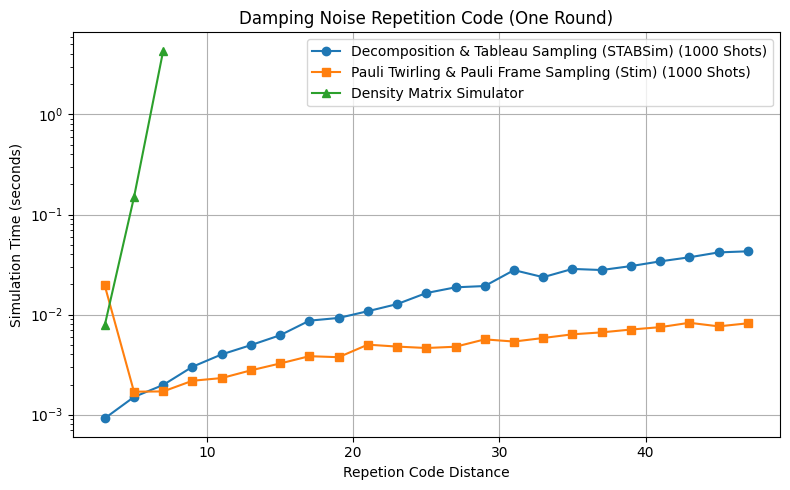

In [5]:
import matplotlib.pyplot as plt


# Plotting
plt.figure(figsize=(8, 5))
plt.plot(distances, stab_times, marker='o', label='Decomposition & Tableau Sampling (STABSim) (1000 Shots)')
plt.plot(distances, stim_times, marker='s', label='Pauli Twirling & Pauli Frame Sampling (Stim) (1000 Shots)')
plt.plot(distances[:len(qiskit_times)], qiskit_times, marker='^', label='Density Matrix Simulator')

plt.yscale('log')


plt.xlabel('Repetion Code Distance')
plt.ylabel('Simulation Time (seconds)')
plt.title('Damping Noise Repetition Code (One Round)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
